# Lab07 - Learning in Reproducing Kernel Hilbert Spaces
Author: [Yunting Chiu](https://www.linkedin.com/in/yuntingchiu/) adapted from Dr. Zois Boukouvalas


# Install the required packages

In [61]:
import matplotlib.pyplot as plt
import math
import numpy as np
import sysa
import os

# Exercise 1

For this exercise, the performance of the SVM is tested in the context of a two-class two- dimensional classification task. The data set comprises $N$ = 150 points uniformly distributed in the region $[−5, 5] \times [−5, 5]$. For each point $x_n = [x_n,1, x_n,2]^T$, we compute 

<br/> 
$$
y_n = 0.05x^3_{n,1} + 0.05x^2_{n,1} + 0.05x_{n,1} + 0.05 + \eta,
$$
<br/>
where $\eta$ stands for zero mean Gaussian noise of variance $\sigma^2_{\eta}$ = 4. The point is assigned to either of the two classes, depending on the value of the noise as well as its position with respect to the graph of the function

<br/>
$$
f (x) = 0.05x^3 + 0.05x^2 + 0.05x + 0.05
$$

in the two-dimensional space. That is, if $x_{n,2} \geq y_n$, the point is assigned to class $w1$; otherwise, it is assigned to class $w2$.

In [62]:
def kappa(x, y, kernel_type, kernel_params): 
  value = None
  if kernel_type == 'gaus':
    sigma = kernel_params[0]
    N = x.shape[0]
    norm = np.sum((x-y)**2)
    value = np.exp(-norm/(sigma**2))
  elif kernel_type == 'gaus_c':
    sigma = kernel_params[0]
    N = len(x)
    exponent = sum( (x-y.conj())**2 )
    # value = 2*(math.exp( -np.real(exponent)/(sigma**2) )) 
    value = 2*np.real(np.exp(-exponent/(sigma**2)))
  elif kernel_type == 'linear': 
    value = 0
    N = len(x)
    for i in range(0, N):
      value = value + x[i]*y[i].conj() 
  elif kernel_type == 'poly':
    d = kernel_params[0]
    value = (1 + np.dot(x, y.conj().transpose()))**d
  # value = ( (1 + x*y.transpose())/( math.sqrt(np.real(x*x.transpose())* np.real(y*y.transpose()) ) ) )**d; 
  elif kernel_type == 'poly_c':
    d = kernel_params[0]
    value = 2*np.real((1 + np.dot(x, y.conj().transpose()))**d)
  # value = 2*np.real( ( (1 + x*y.transpose())/( math.sqrt(np.real(x*x.transpose()) * np.real(y*y.transpose()) ) ) )**d ) 
  return value

In [63]:
global a1_g, a2_g, b_g, u_g, KKT_g, NB_g, a1i_new, a1j_new, a2i_new, a2j_new
"""
# SMO algorithm for classification.
# The Algorithm computes the parameters a_k, of the expansion of the solution w = Sum a_n*K(. , x_n) and the parameter b.
# -------------------------------------------------------------------
# input variables
# x:
# y:
# C:
# -----------------------------------------------------------------
# output variables
# a  :
# b  :
"""
global a1_g, a2_g, b_g, u_g, KKT_g, NB_g, a1i_new, a1j_new, a2i_new, a2j_new

def SMO_classification(x, y, C, epsilon, kernel_type, kernel_params):
  global a_g, b_g, u_g, KKT_g, NB_g 
  tol = 0.001
  [M, N] = x.shape
  Kernel_matrix = np.zeros(shape=(M, M))
  if kernel_type == 'gaus':
    par = kernel_params
    norms = np.zeros(shape=(M, M)) 
    for i in range(0, M):
      T = x - x[i, :] # bsxfun(@minus,x,x(i,:)) 
      norms[i, :] = np.sum(T ** 2, axis=1)

    Kernel_matrix[:, :] = np.exp(-norms / (par ** 2)) 
  else:
    for i in range(0, M): 
      for j in range(0, M):
        Kernel_matrix[i, j] = kappa(x[i, :], x[j, :], kernel_type, kernel_params)
  # initialize the support vectors
  a_g = np.zeros(shape=(M, )) #initialize the threshold
  b_g = 0
  #u contains the values of the sv expansion for each input
  u_g = np.zeros(shape=(M, ))
  # KKT(i) is 1 if the i-th sv (a(i)) satisfies the KKT conditions # KKT(i) is 0 otherwise
  KKT_g=np.zeros(shape=(M, ))

  # Update KKT conditions
  for k in range(0, M):
    r2 = (u_g[k]-y[k])*y[k]
    if ((r2 < -tol) and (a_g[k] < C)) or ((r2 > tol) and (a_g[k] > 0) ):
      KKT_g[k] = 0 # KKT condition not satisfied 
    else:
      KKT_g[k] = 1

  # NB(i) is 1 if the sv a(i) is non bound, i.e. 0<a(i)<C # NB(i) is 0 otherwise.
  NB_g = np.zeros(shape=(M, ))

  numChanged=0
  examineAll=1

  while (numChanged > 0) or (examineAll == 1):
    numChanged=0
    if examineAll==1:
      # loop over all training examples
      for i in range(0, M):
        numChanged = numChanged + examineExample(i, x, y, C, epsilon,Kernel_matrix)
    else:
      # loop over all training examples, where a(i) is non-bound 
      for i in range(0, M):
        if (NB_g[i] == 1):
          numChanged = numChanged + examineExample(i, x, y, C,epsilon, Kernel_matrix)
    if examineAll == 1: 
      examineAll = 0
    elif numChanged == 0: 
      examineAll = 1
  a = np.array(a_g)
  b = np.array(b_g)

  print('SMO Finished')
  return a, b

In [64]:
def examineExample(j, x, y, C, epsilon, Kernel_matrix):
  global u_g, KKT_g, NB_g
  M = y.shape[0]
  E_j = u_g[j] - y[j]
  if KKT_g[j] == 0:
    if np.sum(NB_g) > 1 :
      # find the i - second choice heurestic
      i = second_choice_heurestic(j, x, y)
      if takeStep(i, j, x, y, C, epsilon, Kernel_matrix):
        ret = 1
        return ret

  # loop over all non-bound a's starting at a random point
    i0 = np.random.randint(low=0, high=M)
    for i in range(i0,i0+M):
      if NB_g[(i) % (M)] == 1:
        if takeStep((i) % (M), j, x, y, C, epsilon, Kernel_matrix):
          ret = 1
          return ret
  # loop over all possible a's starting at a random point
    i0 = np.random.randint(low=0, high=M)
    for i in range(i0,i0+M):
      if takeStep((i) % (M), j, x, y, C, epsilon, Kernel_matrix) == 1:
        ret = 1
        return ret
  ret = 0
  return ret

In [65]:
def takeStep(i,j, x, y, C, epsilon, Kernel_matrix):
  global a_g, b_g, u_g, KKT_g, NB_g
  tol = 0.001

  if (i == j):
    ret=0
    return ret
  E_i = u_g[i] - y[i]
  E_j = u_g[j] - y[j]
  s = y[i]*y[j]

  # compute L, H
  if y[i] != y[j]:
    L = np.maximum(0, a_g[j]-a_g[i])
    H = np.minimum(C, C+a_g[j]-a_g[i])
  else:
    L = np.maximum(0, a_g[j]+a_g[i]-C)
    H = np.minimum(C, a_g[j]+a_g[i])

  if L==H:
    ret = 0
    return ret
  kii = Kernel_matrix[i, i]
  kij = Kernel_matrix[i, j]
  kjj = Kernel_matrix[j, j]
  eta = kii + kjj - 2*kij

  if eta > 0:
    aj_new = a_g[j] + y[j]*(E_i - E_j)/eta
    if aj_new < L:
      aj_new = L
    elif aj_new>H:
      aj_new = H
  else:
  # when numerical errors are involved
    kij = Kernel_matrix[i,j]
    f1 = y[i]*(E_i+b_g) - a_g[i]*Kernel_matrix[i, i] - s*a_g[j]*Kernel_matrix[i, j]
    f2 = y[j]*(E_j+b_g) - s*a_g[i]*Kernel_matrix[i, j] - a_g[j]*Kernel_matrix[j, j]
    L1 = a_g[i] + s*(a_g[j] - L)
    H1 = a_g[i] + s*(a_g[j] - H)
    Psi_L = L1*f1 + L*f2 + 0.5*L1**2*Kernel_matrix[i, i] + 0.5*L**2*Kernel_matrix[j, j] + s*L*L1*Kernel_matrix[i, j]
    Psi_H = H1*f1 + H*f2 + 0.5*H1**2*Kernel_matrix[i, i] + 0.5*H**2*Kernel_matrix[j, j] + s*H*H1*Kernel_matrix[i, j]
    L_obj = Psi_L
    H_obj = Psi_H
    if L_obj < (H_obj - epsilon):
      aj_new = L
    else:
      if L_obj > (H_obj + epsilon):
        aj_new = H
      else:
        aj_new = a_g[j]

  if ( np.abs(aj_new - a_g[j]) < epsilon*(aj_new + a_g[j] + epsilon) ):
    ret = 0
    return ret
  ai_new = a_g[i] + s*(a_g[j] - aj_new)

  #Update threshold b
  b1 = E_i + y[i]*(ai_new - a_g[i])*Kernel_matrix[i, i] + y[j]*(aj_new - a_g[j])*Kernel_matrix[i, j] + b_g
  b2 = E_j + y[i]*(ai_new - a_g[i])*Kernel_matrix[i, j] + y[j]*(aj_new - a_g[j])*Kernel_matrix[j, j] + b_g
  if (ai_new > 0) and (ai_new < C):
    b_g = b1
  elif (aj_new > 0) and (aj_new < C):
    b_g = b2
  else:
    b_g = (b1+b2)/2

  ret = 1
  # Update a vector
  a_g[i] = ai_new
  a_g[j] = aj_new

  # Update u vector
  M = y.shape[0]
  for k in range(0, M):
    u_g[k] = 0
    for l in range(0, M):
      u_g[k] = u_g[k] + y[l]*a_g[l]*Kernel_matrix[k, l]
    u_g[k] = u_g[k] - b_g

  # Update KKT conditions
  for k in range(0, M):
    r2 = float((u_g[k]-y[k])*y[k])
    if ((r2 < -tol) and (float(a_g[k]) < C)) or ((r2 > tol) and (float(a_g[k]) > 0)):
      KKT_g[k] = 0 # KKT condition not satisfied
    else:
      KKT_g[k] = 1

  # Update NB vector
  for k in range(0, M):
    if (a_g[k] > 0) and (a_g[k] < C):
      NB_g[k] = 0 # Bound example
    else:
      NB_g[k] = 1 # non Bound example
  return ret

In [66]:
def second_choice_heurestic(j,x,y):
  global a_g, b_g, u_g, KKT_g, NB_g
  maximum = np.abs( u_g[0]- y[0] - ( u_g[j] - y[j] ))
  i=0
  M=len(y)
  for k in range(0,M):
    if np.abs( u_g[k] - y[k] - ( u_g[j] - y[j] ) ) > maximum:
      maximum = np.abs(u_g[k] - y[k] - (u_g[j] - y[j]))
      i=k
  return i

In [67]:
#---------------------------------------------------------------------
# Lab 6
# Support Vector Machine classification
#
# This file uses a simple SMO implementation to train the SVM.
#---------------------------------------------------------------------
import math
import matplotlib.pyplot as plt
import time
import numpy as np

def frange(x, y, jump):
  values = []
  while x < y:
    values.append(x)
    x += jump
  return values

In [68]:
def supportvectormachine_lab6(kernel, C):
  np.random.seed(0)
  print('Starting')
  N=150
  start_time = time.time()

  # ---------Generate Samples-------------------------
  f = lambda x: (0.05*x**3 + 0.05*x**2 + 0.05*x + 0.05)
  X_ = 10*np.random.rand(2,N) - 5
  x_ = X_[0,:]
  y_ = X_[1,:]
  fx = f(x_)

  C1=[]
  C2=[]
  y_training = np.zeros(shape=(N, 1))
  for i in range(0, N):
    if y_[i] < (fx[i] + 2*np.random.randn(1)):
      C1.append(i)
      y_training[i] = +1
    else:
      C2.append(i)
      y_training[i] = -1
  C1 = np.array(C1).conj().transpose()
  C2 = np.array(C2).conj().transpose()

  x_training = np.array([[x_], [y_]]).conj().transpose()
  x_training = np.reshape(x_training, newshape=(x_training.shape[0], x_training.shape[2]))
  #-----------------------------------------------------

  #FOR N = 150
  #Experiment1 C = 20
  #Experiment2 C = 1
  #FOR N=500
  #Experiment1 C=1
  #Experiment1 C=20

  #-----Training---------
  C = C
  epsilon=0.01
  kernel_type = 'gaus'
  kernel_params = kernel
  #kernel_params = math.sqrt(100)
  [a, b] = SMO_classification(x_training, y_training, C, epsilon,kernel_type, kernel_params)
  #-----------------------
  #classifier
  PP = 1.1
  leftX = PP*np.min(x_)
  rightX = PP*np.max(x_)
  leftY = PP*np.min(y_)
  rightY = PP*np.max(y_)
  step = 0.5
  [X, Y] = np.meshgrid(frange(leftX, rightX, step), frange(leftY, rightY, step))
  [K, L] = X.shape
  Z = np.zeros(shape=(K, L))
  for i in range(0, K):
    for j in range(0, L):
      sum = 0
      for n in range(0, N):
        #print(np.array(X[i, j]))
        sum = sum + a[n]*y_training[n]*kappa(np.array(x_training[n, :]), np.array([X[i, j], Y[i, j]]), kernel_type, [kernel_params])
      Z[i, j] = sum-b
        # norm of solution
  norm=0
  for n in range(0, N):
    for m in range(0, N):
      norm = norm + a[n]*a[m]*y_training[n]*y_training[m]*kappa(np.array(x_training[n, :]), np.array(x_training[m, :]), kernel_type,[kernel_params])
  
  # find support vectors
  SV = []
  for n in range(0, N):
    if np.abs(a[n]) > 0.001:
      SV.append(n)
  SV1 = np.intersect1d(C1, SV)
  SV2 = np.intersect1d(C2, SV)

  # plot classifier
  plt.figure(1)
  v = [-1, 0, 1]
  plt.contour(X, Y, Z, v, colors='k', linestyles='dashed', linewidths=0.8)
  # step = 1/norm
  # v = frange(-1*step, 1*step, step)
  v = [0]
  plt.contour(X, Y, Z, v, colors='k', linestyles='solid', linewidths=0.8)
  plt.plot(x_[C1], y_[C1], '.', markersize=4, c=[1, 0, 0])
  plt.plot(x_[C2], y_[C2], '.', markersize=4, c=[0.5, 0.5,0.5])
  # [sx,I] = sort(x_);
  # plot(sx',fx(I)');
  box = PP*np.array([np.min(x_), np.max(x_), np.min(y_), np.max(y_)])
  plt.axis(box)

  # plot Support Vectors
  plt.plot(x_[SV1], y_[SV1], 'o', markerfacecolor='none', markersize=6,markeredgecolor=[1, 0, 0])
  plt.plot(x_[SV2], y_[SV2], 'o', markerfacecolor='none', markersize=6,markeredgecolor=[0.5, 0.5, 0.5])
  plt.title('C= ' + str(C) + ', ' + 'Number of SVs: ' + str(len(SV)))
  plt.show()
  print("--- %s seconds ---" % (time.time() - start_time))

#if __name__ == '__main__':
  #supportvectormachine_lab6()

(a) Plot the points $[x_{n,1},x_{n,2}]$ using different colors for each class.

Starting
SMO Finished


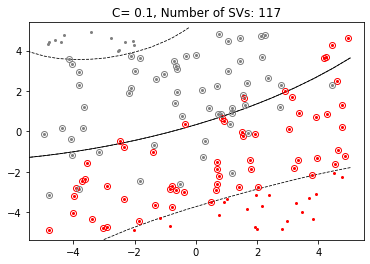

--- 38.11874723434448 seconds ---


In [69]:
kernal = math.sqrt(100)
supportvectormachine_lab6(kernal, 0.1)

(b) Use SVM with the Gaussian kernel for $\sigma$ = 20 and set $C$ = 1. Plot the classifier and the margin. Moreover, find the support vectors (i.e., the points with nonzero Lagrange multipliers that contribute to the expansion of the classifier) and plot them as circled points.

Starting
SMO Finished


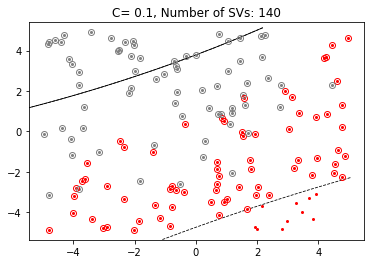

--- 20.10758948326111 seconds ---


In [70]:
supportvectormachine_lab6(20, 0.1)

(c) Repeat step (b) using $C$ = 0.5, 0.1, 0.05.

Starting
SMO Finished


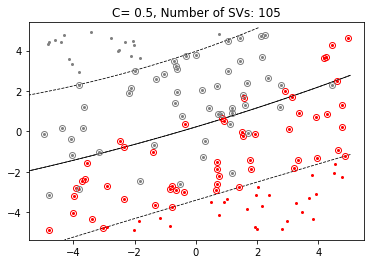

--- 40.6039605140686 seconds ---


In [71]:
supportvectormachine_lab6(20, 0.5)

Starting
SMO Finished


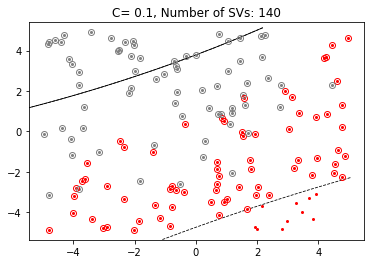

--- 19.601584672927856 seconds ---


In [72]:
supportvectormachine_lab6(20, 0.1)

Starting
SMO Finished


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: No contour levels were found within the data range.


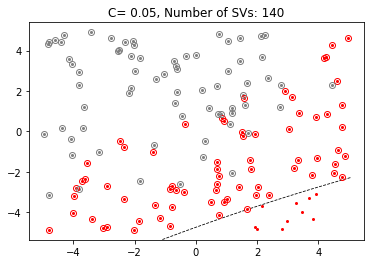

--- 19.64300274848938 seconds ---


In [73]:
supportvectormachine_lab6(20, 0.05)

(d) Repeat step (b) using $C$ = 5, 10, 50, 100.

Starting
SMO Finished


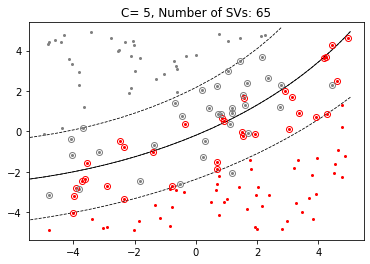

--- 57.922760248184204 seconds ---


In [74]:
supportvectormachine_lab6(20, 5)

Starting
SMO Finished


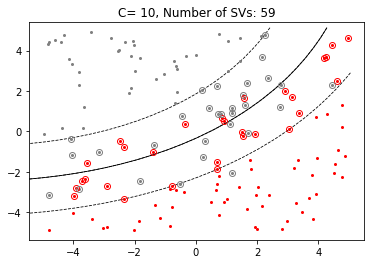

--- 91.65374207496643 seconds ---


In [75]:
supportvectormachine_lab6(20, 10)

Starting
SMO Finished


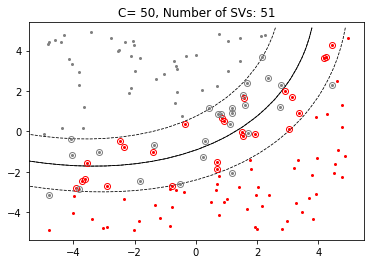

--- 146.73390293121338 seconds ---


In [76]:
supportvectormachine_lab6(20, 50)

Starting
SMO Finished


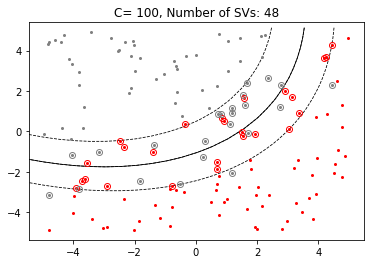

--- 173.7207601070404 seconds ---


In [77]:
supportvectormachine_lab6(20, 100)

(e) Comment on the results.

The algorithm requires more time to run as the regularization parameter ($C$) grows larger. $C$ must be a positive value. also, as $c$ increases, the margin shifts from a linear line to a curved line.

# Output

In [79]:
# should access the Google Drive files before running the chunk
%%capture
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic 
!jupyter nbconvert --to pdf "/content/drive/MyDrive/American_University/2021_Fall/DATA-642-001_Advanced Machine Learning/GitHub/Labs/07/submit/Lab7_Yunting.ipynb"